In [35]:
import cv2
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
import math
import csv

def imshow(img, format=".jpg", **kwargs):
    """ndarray 配列をインラインで Notebook 上に表示する。
    """
    img = cv2.imencode(format, img)[1]
    img = display.Image(img, **kwargs)
    display.display(img)


img = cv2.imread("img/IMG_0653.JPG")
height, width = img.shape[:2]

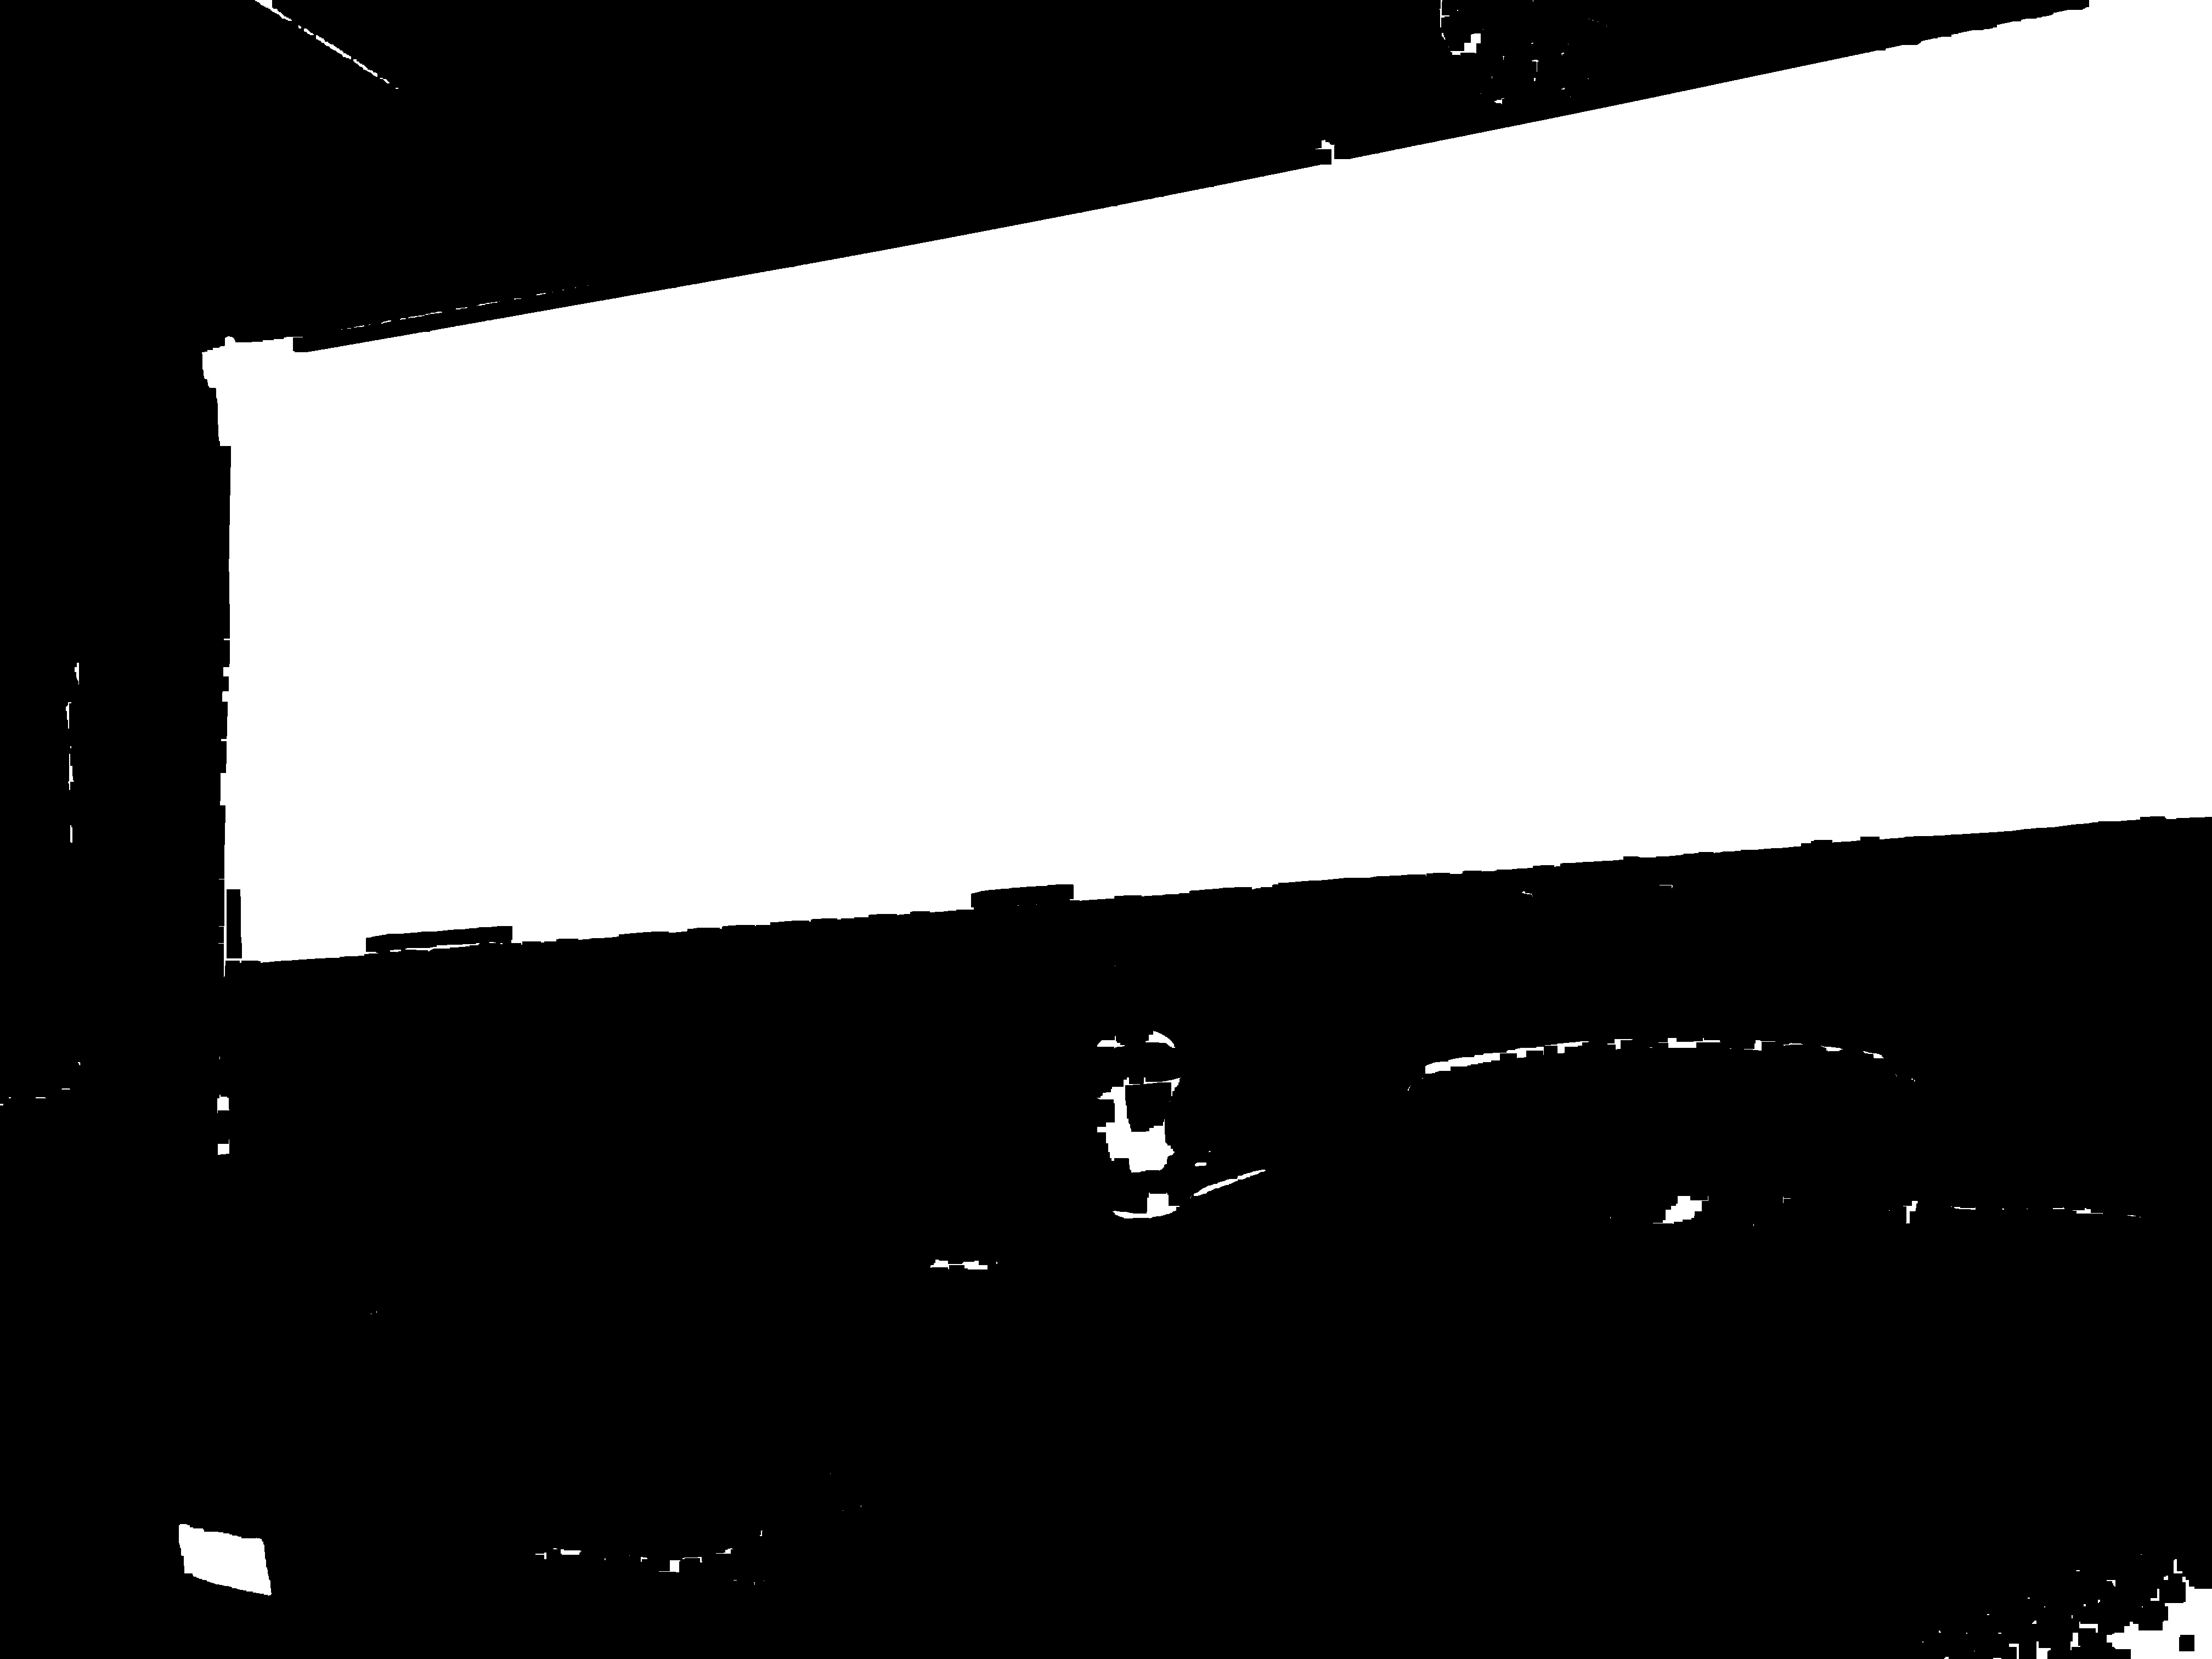

In [36]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lowerHSV = (50, 0, 0)
upperHSV = (110,150, 150)
bin_img = cv2.inRange(hsv, lowerHSV, upperHSV)

#クロージング処理
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25)) #フィルタ
closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
imshow(closing)

#result = cv2.bitwise_and(img, img, mask=closing) # 元画像とマスクを合成
#imshow(result)

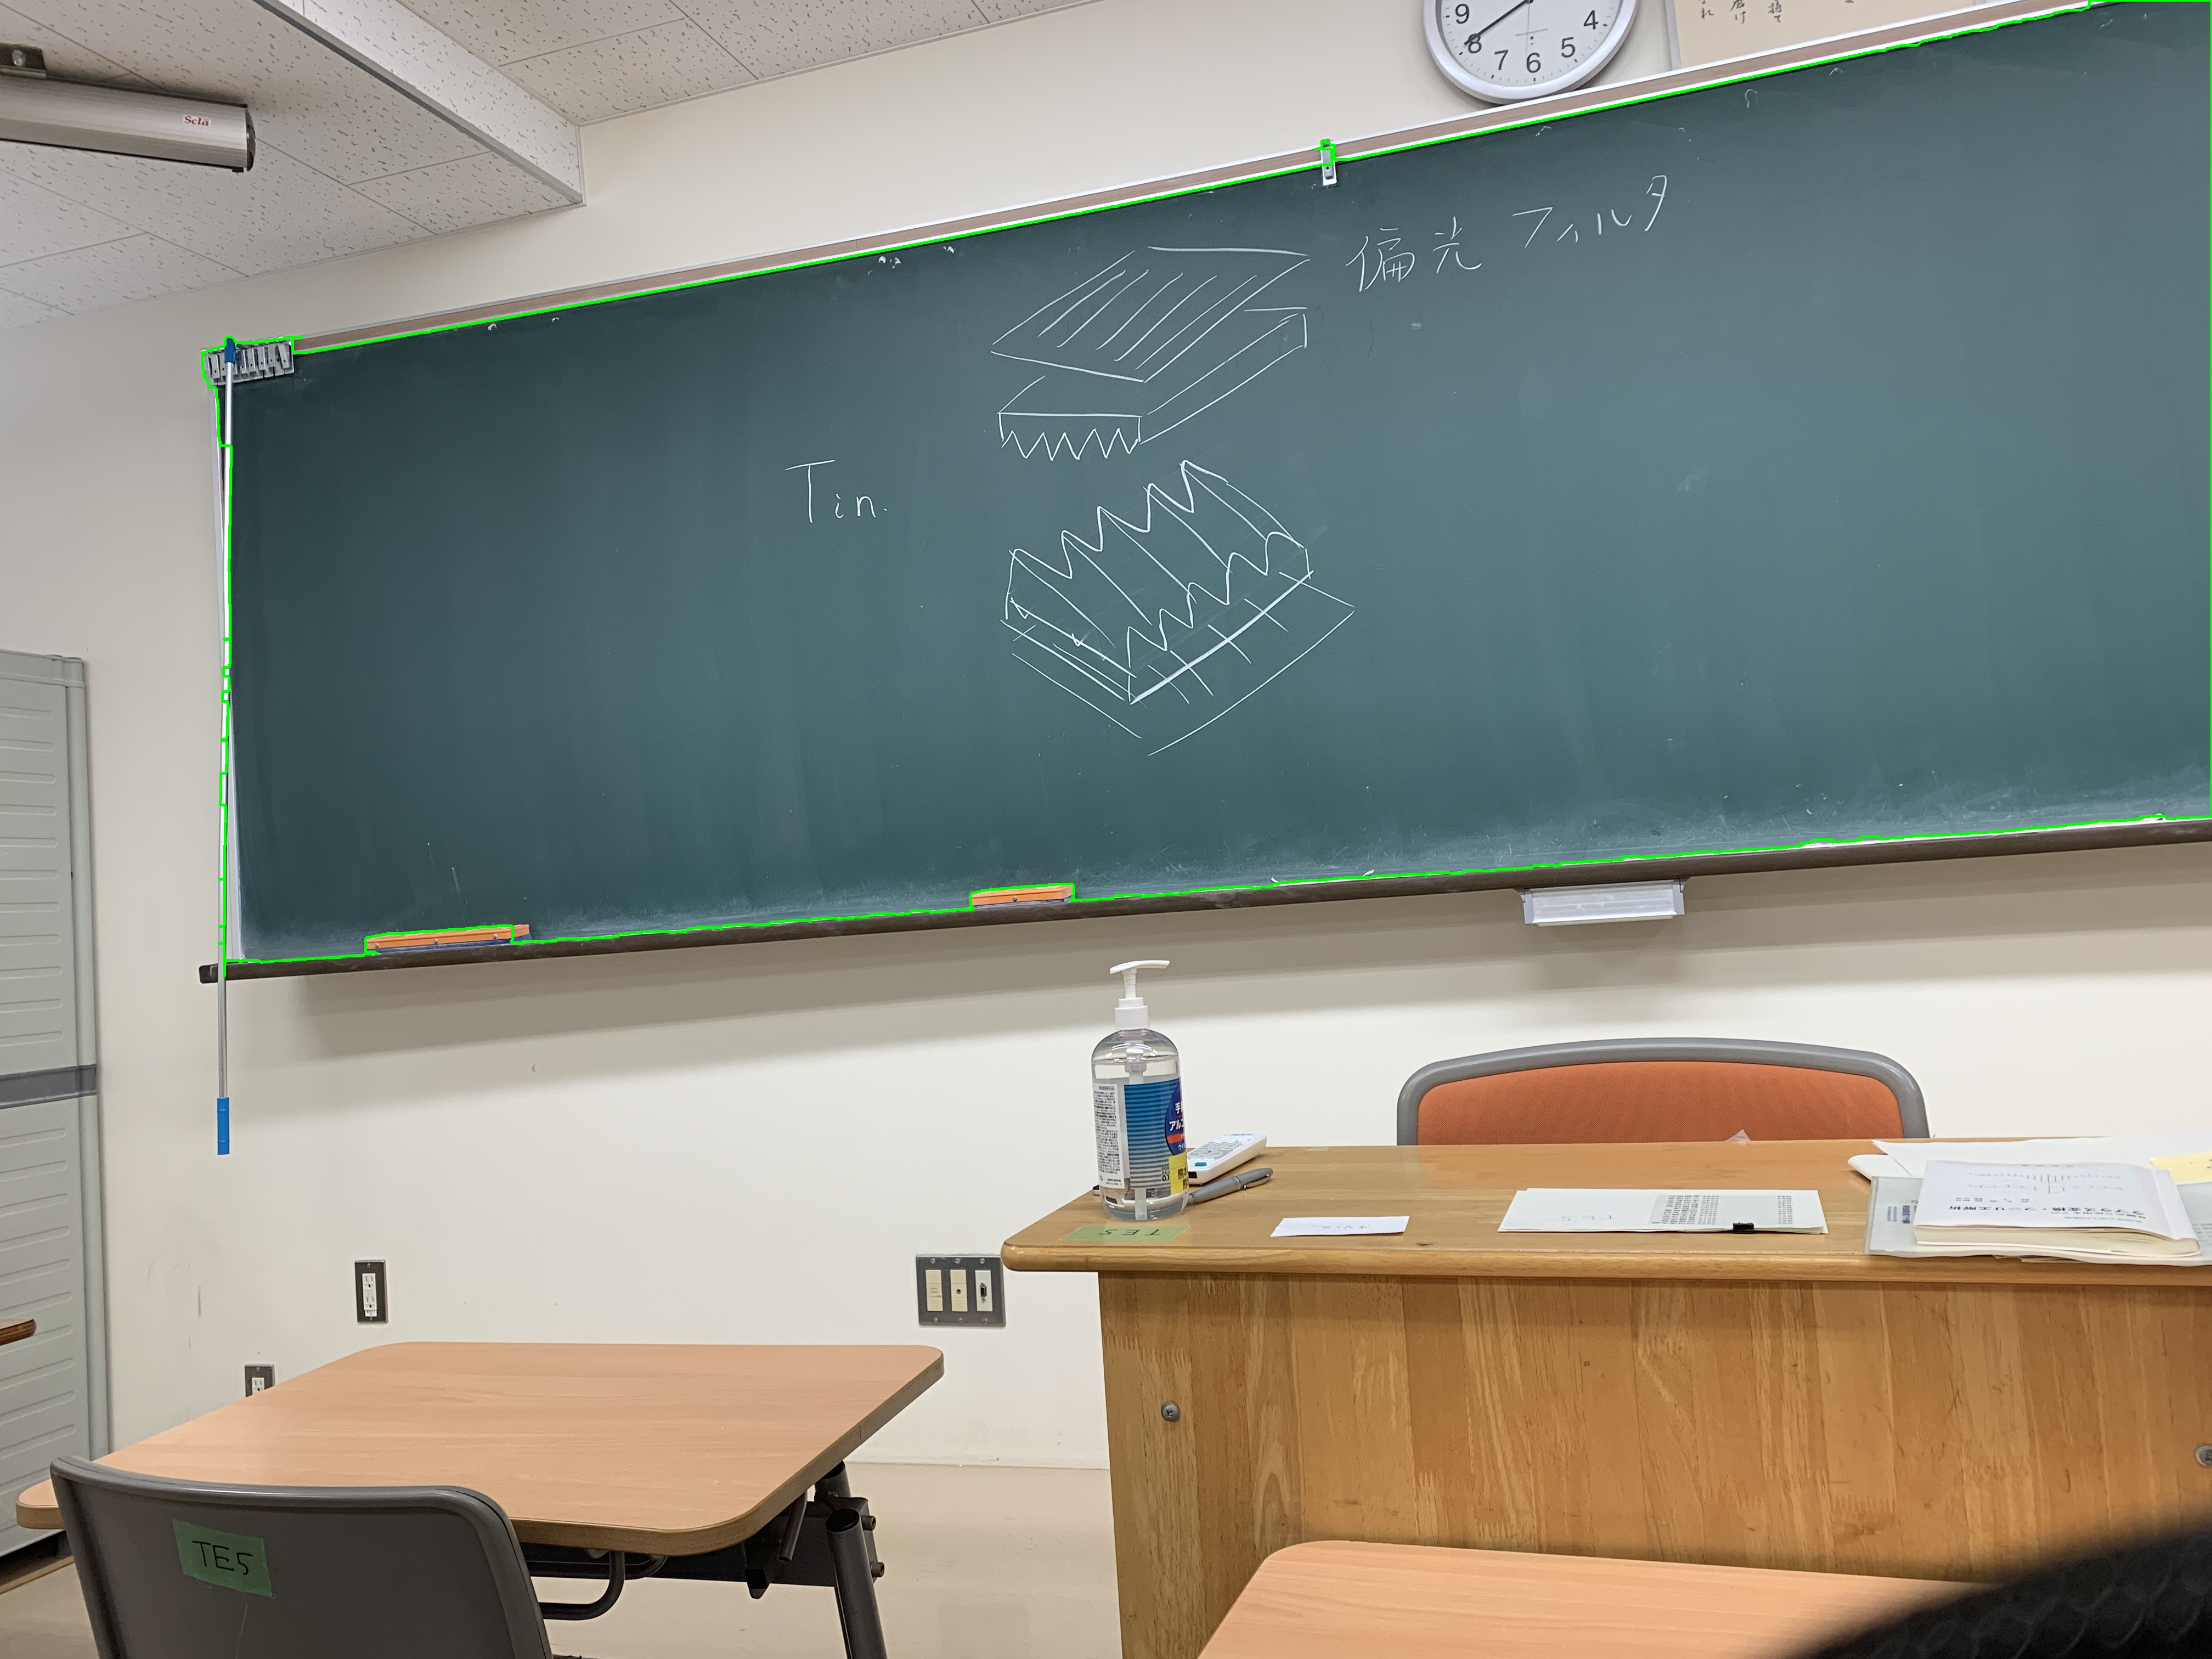

In [37]:
#輪郭を生成する処理があるcell
contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
con = list(filter(lambda x: cv2.contourArea(x) > (height*width/5), contours)) #閾値設定

output1 = img.copy()
output1 = cv2.drawContours(output1, con, -1, (0,255,0), 3)
imshow(output1)

contour 0: before: 1991, after: 4
[[ 415  613]
 [ 408 1780]
 [4031    0]
 [4031 1488]]


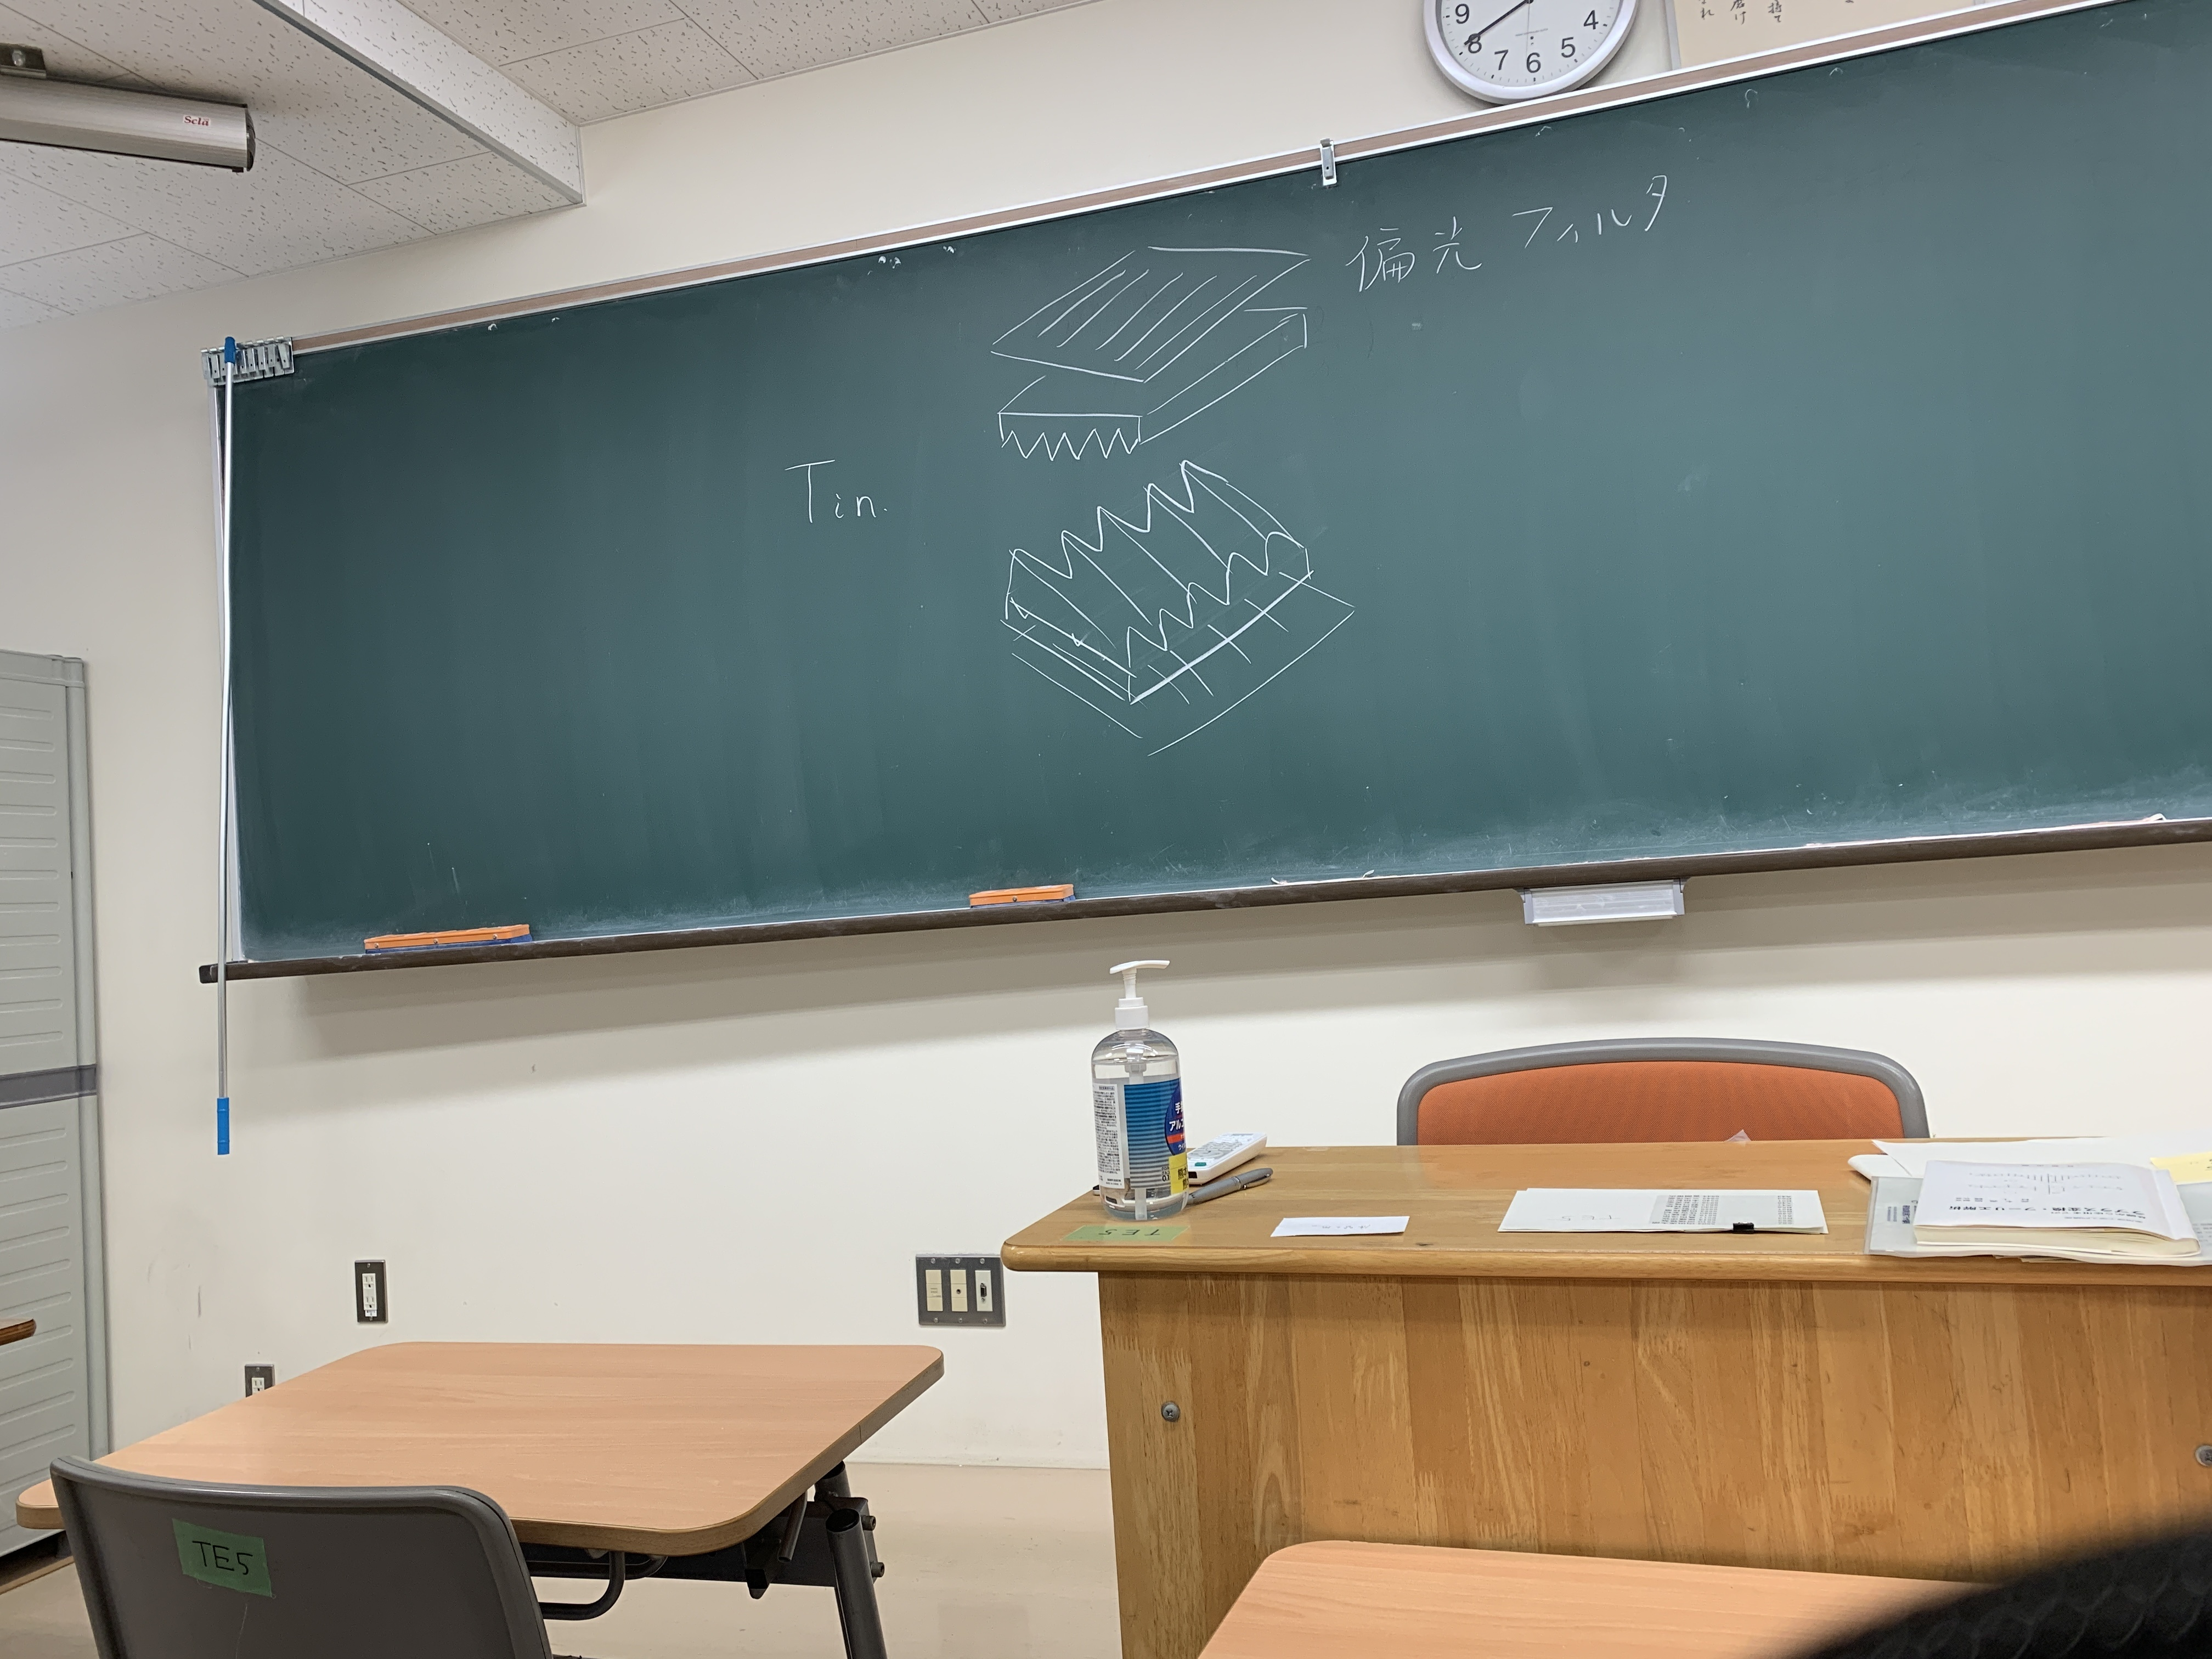

In [38]:
# 輪郭の近似をする処理があるcell
approx_contours = []
for i, cnt in enumerate(con):
    # 輪郭の周囲の長さを計算する。
    arclen = cv2.arcLength(cnt, True)
    # 輪郭を近似する。
    n = 1
    while True:
        approx_cnt = cv2.approxPolyDP(cnt, epsilon=n * 0.01 * arclen, closed=True)
        if len(approx_cnt) == 4:
            break
        elif len(approx_cnt) < 4:
            n -= 0.4
        else:
            n += 1

# 元の輪郭及び近似した輪郭の点の数を表示する。
print(f"contour {i}: before: {len(cnt)}, after: {len(approx_cnt)}")

# 次元を減らして要素をsort
# sort後の順番:左上→左下→右上→右下
approx_cnt = np.squeeze(approx_cnt)
approx_cnt_sort = approx_cnt[np.argsort(approx_cnt[:, 0])]
if approx_cnt_sort[0][1] > approx_cnt_sort[1][1]:
    approx_cnt_sort = approx_cnt_sort[[1,0,2,3], : ]
if approx_cnt_sort[2][1] > approx_cnt_sort[3][1]:
    approx_cnt_sort = approx_cnt_sort[[0,1,3,2], : ]


#4頂点の座標をcsvファイルとして保存
print(approx_cnt_sort)
with open('vertices.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(approx_cnt_sort)

    
#4頂点から得た輪郭を描画
output2 = img.copy()
output2 = cv2.drawContours(output2, approx_contours, 0, (255,0,0), 2)
imshow(output2)

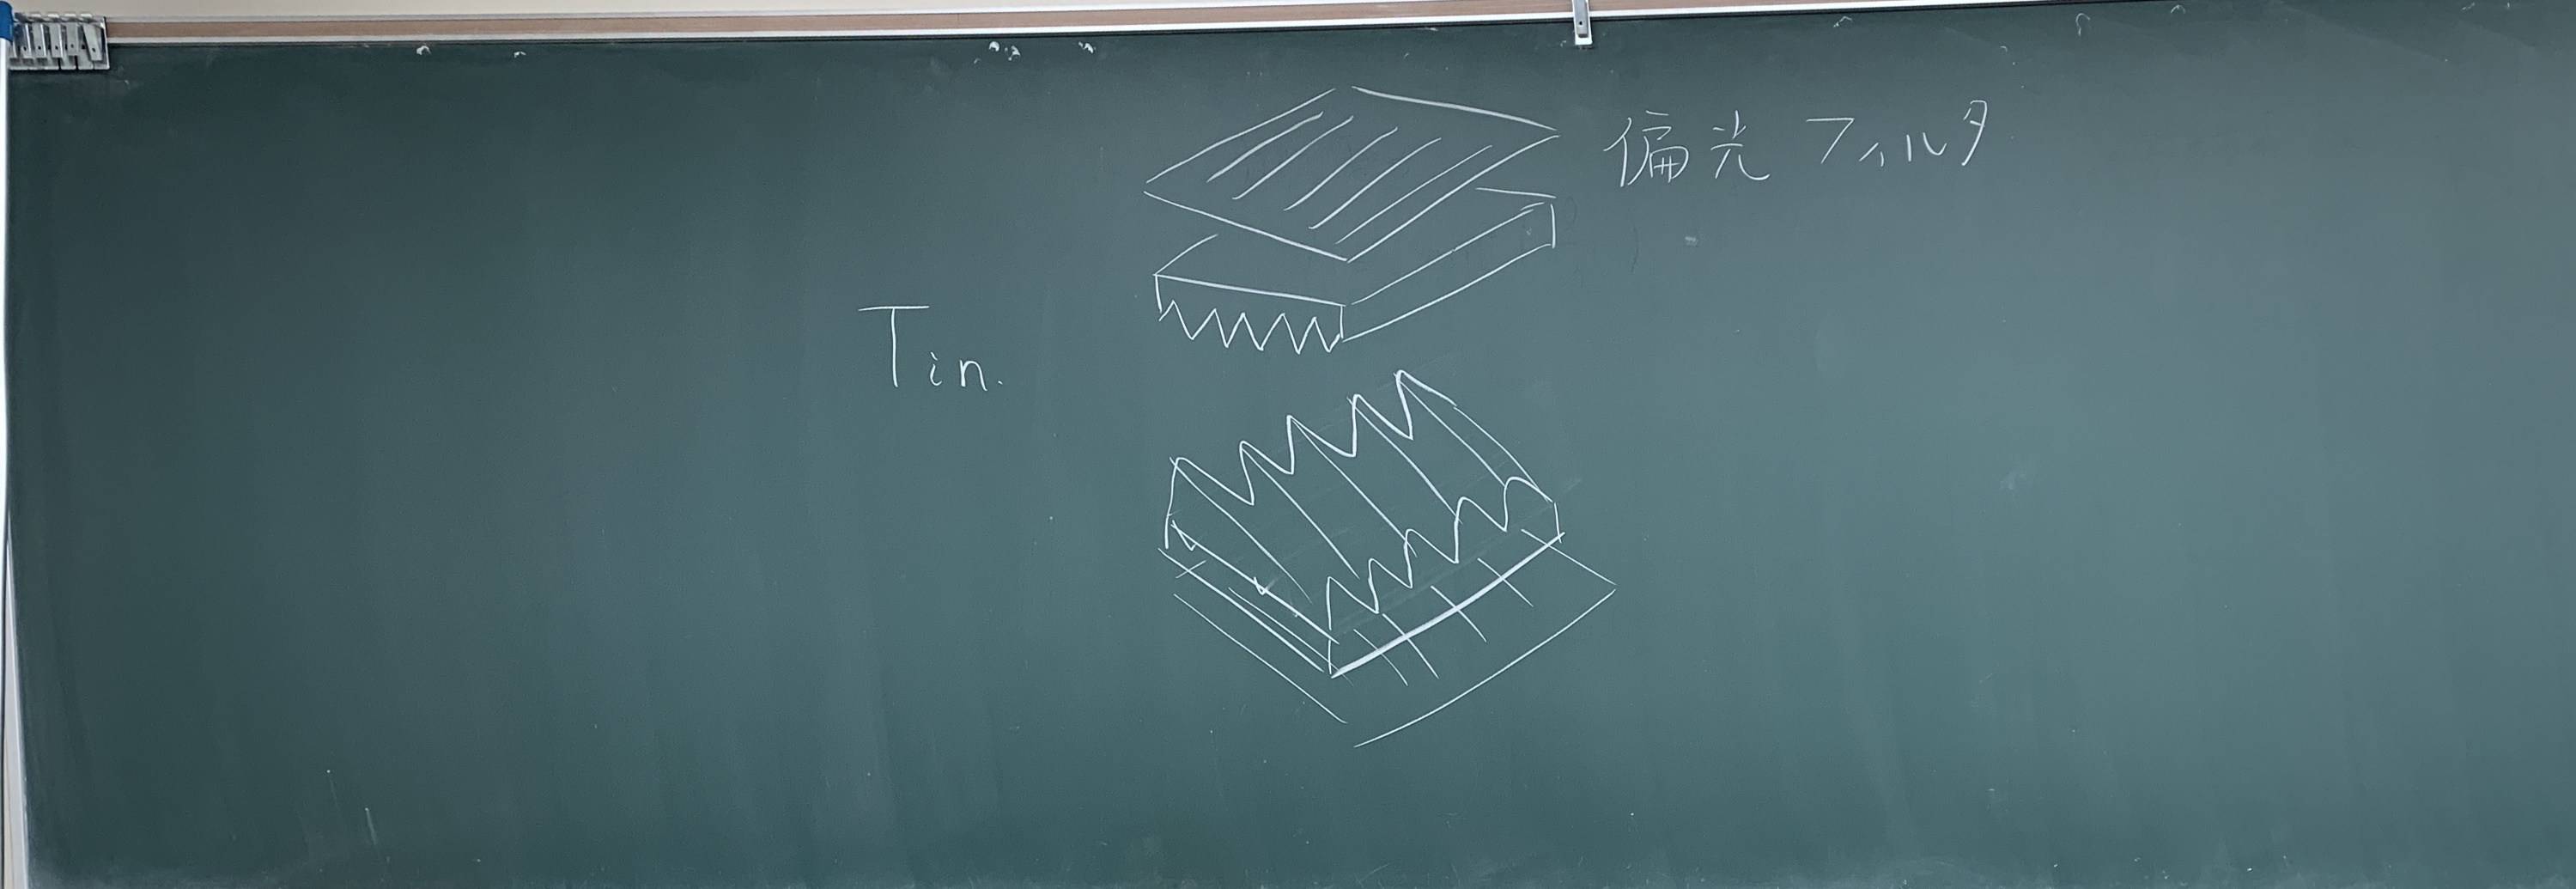

In [39]:
#下部5%を削除する
approx_cnt_sort[1][1] = approx_cnt_sort[1][1]-((approx_cnt_sort[1][1]-approx_cnt_sort[0][1])*0.05)
approx_cnt_sort[3][1] = approx_cnt_sort[3][1]-((approx_cnt_sort[3][1]-approx_cnt_sort[2][1])*0.05)

outputWidth = 3000
def get_distance(x1,y1,x2,y2):
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance

def get_aspectRatio(array):
    #4つの辺の長さを取得
    height1 = get_distance(array[0][0],array[0][1],array[1][0],array[1][1])
    height2 = get_distance(array[2][0],array[2][1],array[3][0],array[3][1])
    width1 = get_distance(array[0][0],array[0][1],array[2][0],array[2][1])
    width2 = get_distance(array[1][0],array[1][1],array[3][0],array[3][1])
    
    #平均を計算
    heightRatio = (height1+height2) / 2
    widthRatio = (width1+width2) / 2
    
    #アスペクト比を少数で取得し返り値として指定
    aspectRatio = heightRatio / widthRatio
    return aspectRatio

aspectRatio = get_aspectRatio(approx_cnt_sort)
outputHeight = int(outputWidth*aspectRatio)

pts1 = np.float32(approx_cnt_sort)
pts2 = np.float32([[0,0],[0,outputHeight],[outputWidth,0],[outputWidth,outputHeight]])

 # 透視変換の行列を求める
M = cv2.getPerspectiveTransform(pts1,pts2)

# 変換行列を用いて画像の透視変換
output3 = cv2.warpPerspective(img,M,(outputWidth,outputHeight))

imshow(output3)